# Global analysis
For gps+argos, drogued, <25km, <30min

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import bootstrap

import dask.dataframe as dd
import os
from glob import glob

import matplotlib.pyplot as plt

import matplotlib.transforms as mtransforms

import histlib.matchup as match
from histlib.diagnosis import (
    build_matchup_dataframe,
    synthetic_figure,
    path_csv,
    put_fig_letter,
    lonlat_stats,
)
from histlib.cstes import labels, zarr_dir, matchup_dir, c0, U

U2 = U**2

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [3]:
DL, DT = 25e3, 30 * 60
# if not already generated
comb_av_d = {
    "acc": "drifter_acc_x_25",
    "cor": "drifter_coriolis_x_25",
    "ggx": "aviso_drifter_ggx_adt",
    "wd": "es_cstrio_z15_drifter_wd_x",
}
comb_av_al = {
    "acc": "drifter_acc_x_25",
    "cor": "drifter_coriolis_x_25",
    "ggx": "aviso_drifter_ggx_adt",
    "wd": "es_cstrio_z15_alti_wd_x",
}
comb_alg = {
    "acc": "drifter_acc_x_25",
    "cor": "drifter_coriolis_x_25",
    "ggx": "alti_ggx_adt_filtered_ocean_tide_internal_tide",
    "wd": "es_cstrio_z15_drifter_wd_x",
}

# df_av_d = build_matchup_dataframe(comb_av_d, 'both', True, DL, DT, store=True)
# df_av_al = build_matchup_dataframe(comb_av_al, 'both', True, DL, DT, store=True)
# df_alg = build_matchup_dataframe(comb_alg, 'both', True, DL, DT, store=True)

df_av_d = (
    dd.read_csv(path_csv(comb_av_d, "both", True, DL, DT))
    .repartition(npartitions=10)
    .persist()
)
df_av_al = dd.read_csv(path_csv(comb_av_al, "both", True, DL, DT))
df_alg = (
    dd.read_csv(path_csv(comb_alg, "both", True, DL, DT))
    .repartition(npartitions=10)
    .persist()
)

In [4]:
def global_stast(df):
    from histlib.cstes import U

    # Mean
    mean = df.mean().compute()
    nb_coloc = len(df)
    mean["nb_coloc"] = nb_coloc

    # Central limit theorem
    errors = (2 * df.std() / np.sqrt(nb_coloc)).compute()

    df = pd.DataFrame([mean, errors], index=["value", "errors"]).transpose() / (U**2)

    df["percentage"] = df.value / df.value.sigma * 100
    df["percentage_erros"] = df.percentage * np.sqrt(
        (df.errors / df.value) ** 2 + (df.errors.sigma / df.value.sigma) ** 2
    )

    return df

_________________
# Along-track

In [5]:
DL, DT = 25e3, 30 * 60
comb_alg = {
    "acc": "drifter_acc_x_25",
    "cor": "drifter_coriolis_x_25",
    "ggx": "alti_ggx_adt_filtered_ocean_tide_internal_tide",
    "wd": "es_cstrio_z15_drifter_wd_x",
}
df_alg = dd.read_csv(path_csv(comb_alg, "both", True, DL, DT)).repartition(
    npartitions=10
)

In [6]:
len(df_alg)

239203

In [7]:
dfalg = global_stast(df_alg)
dfalg

,value,errors,percentage,percentage_erros
obs,5.750261e+14,2.090045e+12,6.858768e+15,7.755345e+13
acc,3.906361e+02,4.228043e+02,4.659411e+03,5.043352e+03
cor,-2.229967e+02,8.182263e+02,-2.659850e+03,-9.759641e+03
drogue_status,1.039111e+10,0.000000e+00,1.239426e+11,1.327064e+09
ggx,1.970851e+03,7.609455e+02,2.350782e+04,9.079858e+03
wd,-1.304171e+02,1.715550e+02,-1.555583e+03,-2.046334e+03
alti___distance,1.326366e+14,2.974264e+11,1.582056e+15,1.730673e+13
alti___time_difference,9.049134e+12,2.209272e+10,1.079358e+14,1.185341e+12
lat,4.097575e+10,1.680418e+09,4.887485e+11,2.071548e+10
lon,-1.165983e+11,4.384160e+09,-1.390756e+12,-5.437201e+10


_________________
# AVISO drifter

In [8]:
DL, DT = 25e3, 30 * 60
comb_av_d = {
    "acc": "drifter_acc_x_25",
    "cor": "drifter_coriolis_x_25",
    "ggx": "aviso_drifter_ggx_adt",
    "wd": "es_cstrio_z15_drifter_wd_x",
}
df_av_d = (
    dd.read_csv(path_csv(comb_av_d, "both", True, DL, DT))
    .repartition(npartitions=10)
    .persist()
)

In [9]:
len(df_av_d)

238169

In [10]:
dfd = global_stast(df_av_d)
dfd

,value,errors,percentage,percentage_erros
obs,5.745718e+14,2.092100e+12,8.173280e+15,9.528095e+13
acc,4.052289e+02,4.229353e+02,5.764379e+03,6.016589e+03
cor,-3.581029e+02,8.190157e+02,-5.094012e+03,-1.165063e+04
drogue_status,1.039111e+10,0.000000e+00,1.478135e+11,1.636944e+09
ggx,2.656450e+02,5.895306e+02,3.778797e+03,8.386173e+03
wd,-1.255539e+02,1.721115e+02,-1.786004e+03,-2.448364e+03
alti___distance,1.326108e+14,2.981045e+11,1.886387e+15,2.131663e+13
alti___time_difference,9.048973e+12,2.214287e+10,1.287216e+14,1.459897e+12
lat,3.953271e+10,1.682526e+09,5.623526e+11,2.473089e+10
lon,-1.171412e+11,4.396924e+09,-1.666333e+12,-6.521169e+10


_________________
# AVISO alti

In [11]:
DL, DT = 25e3, 30 * 60
comb_av_a = {
    "acc": "drifter_acc_x_25",
    "cor": "drifter_coriolis_x_25",
    "ggx": "aviso_alti_ggx_adt",
    "wd": "es_cstrio_z15_drifter_wd_x",
}
df_av_a = (
    dd.read_csv(path_csv(comb_av_a, "both", True, DL, DT))
    .repartition(npartitions=10)
    .persist()
)

In [12]:
len(df_av_a)

238552

In [13]:
dfa = global_stast(df_av_a)
dfa

,value,errors,percentage,percentage_erros
obs,5.746562e+14,2.091153e+12,8.132948e+15,9.446176e+13
acc,4.300143e+02,4.227919e+02,6.085872e+03,5.984032e+03
cor,-3.454547e+02,8.187825e+02,-4.889123e+03,-1.158812e+04
drogue_status,1.039111e+10,0.000000e+00,1.470625e+11,1.622088e+09
ggx,4.651135e+02,5.936296e+02,6.582621e+03,8.401786e+03
wd,-1.275473e+02,1.719256e+02,-1.805142e+03,-2.433296e+03
alti___distance,1.326408e+14,2.978425e+11,1.877228e+15,2.113040e+13
alti___time_difference,9.049061e+12,2.212368e+10,1.280688e+14,1.446875e+12
lat,4.010998e+10,1.682038e+09,5.676652e+11,2.461507e+10
lon,-1.170695e+11,4.392036e+09,-1.656852e+12,-6.479002e+10


________________
# Synthetic figures

In [14]:
def synthetic_figure(df, ax, xlim=None, aviso=False):
    from histlib.cstes import U

    plt.rcParams["axes.edgecolor"] = "w"
    a = 1.5
    bbox = dict(facecolor="w", alpha=0.8, edgecolor="w")

    ts = df["sigma"]
    print(ts)
    # gap between bars for readability
    if xlim:
        b = xlim / 400
    else:
        b = ts / 400

    # b = 1e-10

    ## INDIVIDUAL MS ##
    ax.barh(2 * a, df["ACC"], color=c0["acc"], label="Lagrangian acceleration")
    ax.barh(
        2 * a,
        df["COR"],
        left=df["ACC"] + b,
        color=c0["cor"],
        label="Coriolis acceleration",
    )
    ax.barh(
        2 * a,
        df["GGX"],
        left=df["ACC"] + df["COR"] + 2 * b,
        color=c0["ggx"],
        label="Pressure gradient term",
    )
    ax.barh(
        2 * a,
        df["WD"],
        left=df["ACC"] + df["COR"] + df["GGX"] + 3 * b,
        color=c0["wd"],
        label="Wind term",
    )

    ax.text(ts / 2, 2 * a + 0.5, r"Individual MS $A_i$", ha="center")
    # percentage + MS
    key = ["ACC", "COR", "GGX", "WD"]
    for i in range(len(key)):
        ax.text(
            sum([df[v] for v in key[:i]]) + df[key[i]] / 2 + i * b,
            2 * a,
            f"{int(np.rint((df[key[i]]/ts)*100))} %",
            ha="center",
            bbox=bbox,
        )
        ax.text(
            sum([df[v] for v in key[:i]]) + df[key[i]] / 2 + i * b,
            2 * a - 0.55,
            f"{np.round(df[key[i]],2)}",
            ha="center",
        )

    # accolade
    c = 1e-12 * U**2
    id1 = 0
    id2 = ts + 3 * b
    bx = [id1, id1, id2, id2]
    by = [3.70, 3.75, 3.75, 3.70]
    ax.plot(bx, by, "k-", lw=2)
    ax.text(ts, 3.8, r"$\Sigma$", fontsize=15, ha="center")

    ## CAPTURED PHYSICAL + ERRORS PARTS ##
    plt.rcParams["hatch.linewidth"] = 8
    plt.rcParams["hatch.color"] = "lightgrey"
    ax.barh(1 * a, df["B_acc"], color=c0["acc"])
    ax.barh(1 * a, df["E_acc"], left=df["B_acc"], color=c0["acc"], hatch="/")
    ax.barh(1 * a, df["B_cor"], left=df["B_acc"] + df["E_acc"] + b, color=c0["cor"])
    ax.barh(
        1 * a,
        df["E_cor"],
        left=df["B_acc"] + df["E_acc"] + df["B_cor"],
        color=c0["cor"],
        hatch="/",
    )
    ax.barh(
        1 * a,
        df["B_ggx"],
        left=df["B_acc"] + df["E_acc"] + df["B_cor"] + df["E_cor"] + b,
        color=c0["ggx"],
    )
    if df["E_ggx"] > 0:
        ax.barh(
            1 * a,
            df["E_ggx"],
            left=df["B_acc"] + df["E_acc"] + df["B_cor"] + df["E_cor"] + df["B_ggx"],
            color=c0["ggx"],
            hatch="/",
        )
        ax.barh(
            1 * a,
            df["B_wd"],
            left=df["B_acc"]
            + df["E_acc"]
            + df["B_cor"]
            + df["E_cor"]
            + df["B_ggx"]
            + df["E_ggx"]
            + b,
            color=c0["wd"],
        )
        ax.barh(
            1 * a,
            df["E_wd"],
            left=df["B_acc"]
            + df["E_acc"]
            + df["B_cor"]
            + df["E_cor"]
            + df["B_ggx"]
            + df["E_ggx"]
            + df["B_wd"],
            color=c0["wd"],
            hatch="/",
        )
    else:
        ax.barh(
            1 * a,
            df["B_wd"],
            left=df["B_acc"]
            + df["E_acc"]
            + df["B_cor"]
            + df["E_cor"]
            + df["B_ggx"]
            + 2 * b,
            color=c0["wd"],
        )
        ax.barh(
            1 * a,
            df["E_wd"],
            left=df["B_acc"]
            + df["E_acc"]
            + df["B_cor"]
            + df["E_cor"]
            + df["B_ggx"]
            + df["B_wd"]
            + 2 * b,
            hatch="/",
            color=c0["wd"],
        )
        ax.barh(
            1 * a,
            -df["E_ggx"],
            left=-b + df["E_ggx"],
            color=c0["ggx"],
            hatch="/",
        )

    ax.text(
        ts / 2,
        1 * a + 0.5,
        r"Balanced and errors parts MS $\beta_i$ and $\epsilon_i$",
        ha="center",
    )

    # percentage + MS
    key = ["B_acc", "E_acc", "B_cor", "E_cor", "B_ggx", "E_ggx", "B_wd", "E_wd"]
    for i in range(len(key)):
        d = 0  # vertical +
        dx = 0  # horizontal + on MS
        dxx = 0  # horizontal + on percentage
        if i == len(key) - 1:
            d = -0.1 * a
            dx = 3e-11 / U2
            dxx = 1.5e-11 / U2
        if i == len(key) - 2:
            d = 0.1 * a
        if (
            abs(int(np.rint((df[key[i]] / ts) * 100))) > 0
        ):  # does not plot percentage below 1%
            if df[key[i]] > 0:
                ax.text(
                    sum([df[v] for v in key[:i]]) + df[key[i]] / 2 + i * b / 2 + dxx,
                    a + d,
                    f"{int(np.rint((df[key[i]]/ts)*100))} %",
                    ha="center",
                    bbox=bbox,
                )
            else:
                ax.text(
                    df[key[i]] / 2 - dxx,
                    a + d,
                    f"{int(np.rint((df[key[i]]/ts)*100))} %",
                    ha="center",
                    bbox=bbox,
                )
        d = 0
        if i % 2 == 1:
            d = -0.1 * a
        ax.text(
            sum([df[v] for v in key[:i]]) + df[key[i]] / 2 + i * b / 2 + dx,
            a + d - 0.55,
            f"{np.round(df[key[i]],2)}",
            ha="center",
        )

    ## PAIRS + RESIDUAL ##
    plt.rcParams["hatch.linewidth"] = 8
    plt.rcParams["hatch.color"] = c0["ggx"]
    ax.barh(0, df["X_cor_ggx"], color=c0["cor"], hatch="/")
    plt.rcParams["hatch.color"] = c0["cor"]
    ax.barh(0, df["X_acc_cor"], color=c0["acc"], hatch="/", left=df["X_cor_ggx"] + b)
    plt.rcParams["hatch.color"] = c0["acc"]
    ax.barh(
        0,
        df["X_acc_ggx"],
        color=c0["ggx"],
        hatch="/",
        left=df["X_cor_ggx"] + df["X_acc_cor"] + 2 * b,
    )
    plt.rcParams["hatch.color"] = c0["wd"]
    ax.barh(
        0,
        df["X_cor_wd"],
        color=c0["cor"],
        hatch="/",
        left=df["X_cor_ggx"] + df["X_acc_cor"] + df["X_acc_ggx"] + 3 * b,
    )
    ax.barh(
        0,
        df["S"],
        label="Errors",
        color="lightgrey",
        left=df["X_cor_ggx"]
        + df["X_acc_cor"]
        + df["X_acc_ggx"]
        + df["X_cor_wd"]
        + 4 * b,
    )
    # negative contribution
    plt.rcParams["hatch.color"] = c0["acc"]
    ax.barh(0, -df["X_acc_wd"], color=c0["wd"], hatch="/", left=df["X_acc_wd"] - b)
    plt.rcParams["hatch.color"] = c0["ggx"]
    ax.barh(
        0,
        -df["X_ggx_wd"],
        color=c0["wd"],
        hatch="/",
        left=df["X_acc_wd"] + df["X_ggx_wd"] - 2 * b,
    )

    tts = (
        df["X_cor_ggx"]
        + df["X_acc_cor"]
        + df["X_acc_ggx"]
        + df["X_cor_wd"]
        + 4 * b
        + df["S"]
    )
    print(tts)
    sum_pairs = (
        df["X_cor_ggx"] + df["X_acc_cor"] + df["X_acc_ggx"] + df["X_cor_wd"] + 3 * b
    )
    ax.text(sum_pairs / 2, 0.6, r"Pairs' contributions $X_{ij}$", ha="center")

    # accolade
    c = 1e-12
    id1 = 0
    id2 = sum_pairs
    bx = [id1, id1, id2, id2]
    by = [0.45, 0.5, 0.5, 0.45]
    # ax.plot(bx, by, 'k-', lw=2)
    ax.text(sum_pairs + df["S"] / 2, 0.5, r"$S$", ha="center")

    # percentage + MS
    from itertools import combinations

    correlation = list(combinations(["acc", "cor", "ggx", "wd"], 2))
    key = ["X_cor_ggx", "X_acc_cor", "X_acc_ggx", "X_cor_wd"]
    for i in range(len(key)):
        d = 0
        if aviso and key[i] == "X_acc_ggx":
            d = -0.1 * a

        if (
            abs(int(np.rint((df[key[i]] / ts) * 100))) > 0
        ):  # does not plot percentage below 1%
            ax.text(
                sum([df[v] for v in key[:i]]) + df[key[i]] / 2 + i * b,
                0 + d * 2,
                f"{int(np.rint((df[key[i]]/ts)*100))} %",
                ha="center",
                bbox=bbox,
            )

        ax.text(
            sum([df[v] for v in key[:i]]) + df[key[i]] / 2 + i * b,
            0 - 0.55 + d,
            f"{np.round(df[key[i]],2)}",
            ha="center",
        )

    # negative contribution
    key = ["X_acc_wd", "X_ggx_wd"]
    for i in range(len(key)):
        if abs(int(np.rint((df[key[i]] / ts) * 100))) > 0:
            ax.text(
                sum([df[v] for v in key[:i]]) + df[key[i]] / 2 + i * b,
                0,
                f"{int(np.rint((df[key[i]]/ts)*100))} %",
                ha="center",
                bbox=bbox,
            )
        d = 0
        if i % 2 == 1:
            d = -0.1 * a
        ax.text(
            sum([df[v] for v in key[:i]]) + df[key[i]] / 2 + i * b,
            0 - 0.55 + d,
            f"{np.round(df[key[i]],2)}",
            ha="center",
        )

    key = ["X_cor_ggx", "X_acc_cor", "X_acc_ggx", "X_cor_wd"]
    ax.text(
        sum([df[v] for v in key]) + df["S"] / 2 + i * b,
        0,
        f'{int(np.rint((df["S"]/ts)*100))} %',
        ha="center",
        bbox=bbox,
    )
    ax.text(
        sum([df[v] for v in key]) + df["S"] / 2 + i * b,
        0 - 0.55,
        f'{np.round(df["S"],2)}',
        ha="center",
    )

    # FIGURE SET
    ax.set_yticks([])
    if not xlim:
        xlim = tts
    ax.axvline(0, ls=":", c="grey")
    ax.set_xlim(-0.5, xlim + 0.5)
    ax.set_ylim(-1, 4.1)
    ax.get_yaxis().set_visible(False)
    ax.annotate(
        "",
        xy=(xlim, -1),
        xytext=(-0.5, -1),
        arrowprops={"arrowstyle": "->", "facecolor": "k"},
    )
    ax.set_xlabel(r"$[\gamma^2]$")

8.383810273600547
8.616672494488125
7.029880874668106
7.262493649620944


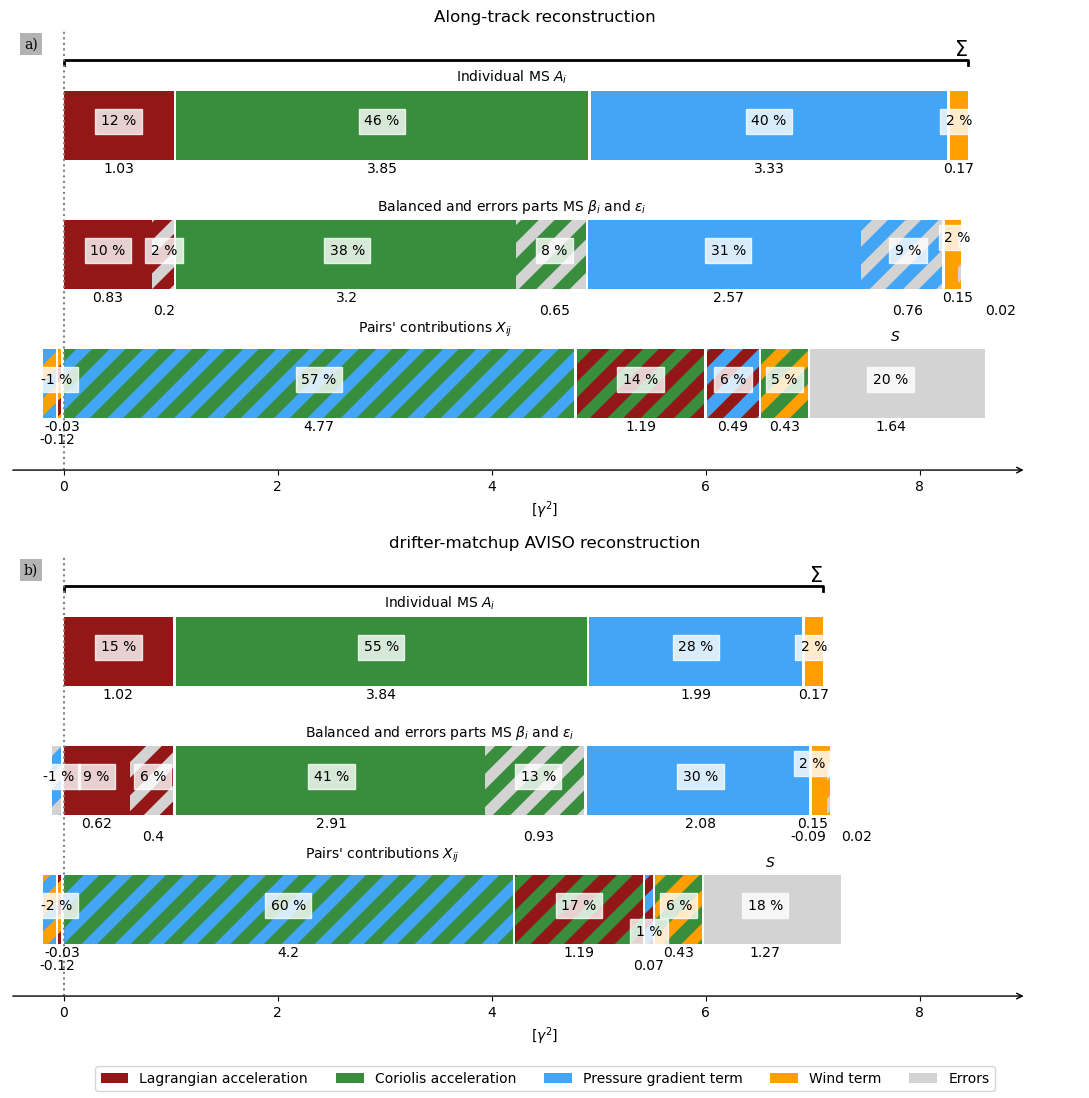

In [17]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(11, 11),
    frameon=False,
)
plt.rcParams["axes.edgecolor"] = "w"

synthetic_figure(dfalg.value, axs[0], xlim=9)
synthetic_figure(dfd.value, axs[1], xlim=9, aviso=True)

axs[0].set_title("Along-track reconstruction")
axs[1].set_title("drifter-matchup AVISO reconstruction")

handles, labels = axs[0].get_legend_handles_labels()

put_fig_letter(fig, axs[0], "a")
put_fig_letter(fig, axs[1], "b")
fig.legend(handles, labels, ncol=5, loc="lower center")
fig.tight_layout(rect=[0, 0.03, 1, 1])  # left, bottom, right, top (default is 0,0,1,1)
# fig.savefig('../images_all/synth_samex.png',bbox_inches='tight',   dpi=300)
# fig.savefig('../images_all/synth_samex.jpeg',bbox_inches='tight',   dpi=300)

8.383810273600547
8.616672494488125
7.06578034776425
7.298903015963676


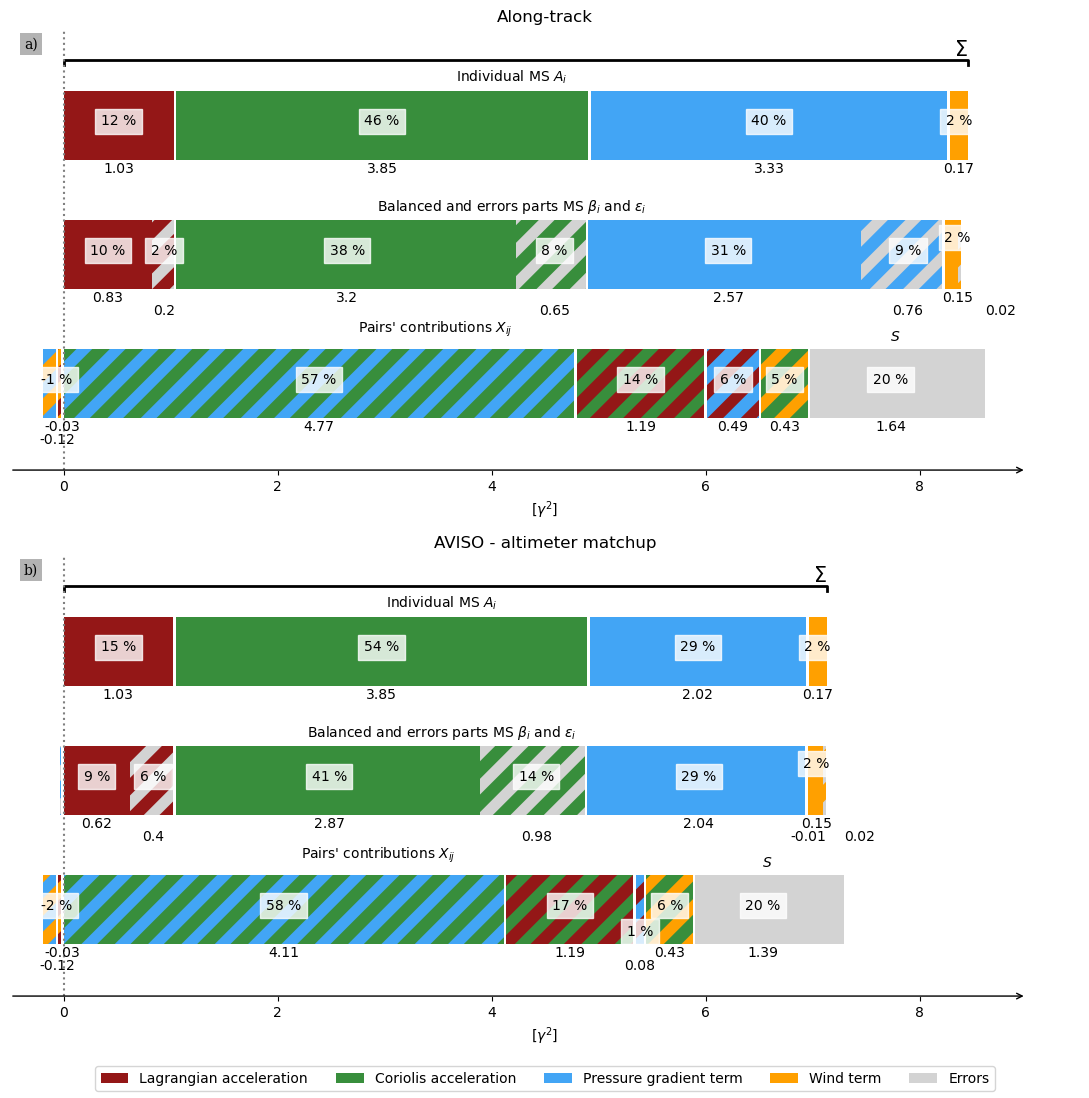

In [18]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(11, 11),
    frameon=False,
)
plt.rcParams["axes.edgecolor"] = "w"

synthetic_figure(dfalg.value, axs[0], xlim=9)
synthetic_figure(dfa.value, axs[1], xlim=9, aviso=True)

axs[0].set_title("Along-track")
axs[1].set_title("AVISO - altimeter matchup")

handles, labels = axs[0].get_legend_handles_labels()

put_fig_letter(fig, axs[0], "a")
put_fig_letter(fig, axs[1], "b")
fig.legend(handles, labels, ncol=5, loc="lower center")
fig.tight_layout(rect=[0, 0.03, 1, 1])  # left, bottom, right, top (default is 0,0,1,1)
# fig.savefig('../images_all/synth_samex_alti.png',bbox_inches='tight',   dpi=300)
# fig.savefig('../images_all/synth_samex_alti.jpeg',bbox_inches='tight',   dpi=300)